In [150]:
#%%writefile cointegration_mult.py

import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts
import matplotlib.pyplot as plt
import statistics
import seaborn as sns; sns.set(style="whitegrid")

def coefficients(y, x, period):
    model = regression(y, x, period)
    return {"temp":model.params['temp'],
            "angular":model.params['x'],
            "intercept":model.params['const']}

def regression(y, x, period):
    y, x = get_values(y, x, period)
    pairs = pd.DataFrame()
    
    pairs['y'] = y
    pairs['x'] = x
    pairs['temp'] = timeline(period)
    
    X = pairs[['x', 'temp']]
    X = sm.add_constant(X)
    model = sm.OLS(pairs['y'], X).fit()
    return model

#O desvio padrão de uma estimativa é chamado de erro padrão
def stderr(y, x, period):
    model = regression(y, x, period)
    return {"temp":model.bse['temp'],
            "angular":model.bse['x'],
            "intercept":model.bse['const']}
    
def residue(y, x, period):
    y, x = get_values(y, x, period)
    coef = coefficients(y, x, period)
    temp = timeline(period)
    res = y-coef['angular']*x-temp*coef['temp']-coef['intercept']
    #res[0]=0
    return res

def timeline(period):
    numbers = np.arange(1, period+1)
    temp = period - numbers + 1
    return temp

def lot(y_lot, coef):
    return [y_lot, int(y_lot*coef['angular'])]

def returns(y, x, period):
    y, x = get_values(y, x, period)
    y_log = np.log(y/y.shift(1))
    x_log = np.log(x/x.shift(1))
    return [y_log, x_log]
    
def get_values(y, x, period):
    if(period <= 0):
        return y, x
    
    y = y.iloc[:period]
    x = x.iloc[:period]
    return y, x

def correlation(y, x, period):
    y_log, x_log = returns(y, x, period)
    return y_log.corr(x_log)

def getdata(data, period):
    data_max = data[:period]
    return data_max

def invert(y, x, period):
    coef_main = coefficients(y, x, period)
    coef_invert = coefficients(x, y, period)
    if (abs(coef_main['temp'])<=abs(coef_invert['temp'])):
        return False
    return True

def ratio_diff(y, x, period):
    coef = coefficients(y, x, period)
    res = residue(y, x, period)
    diff = res.shift(1)-res
    diff[0]=0
    return diff

def ratio_continuo(y, x, period):
    y, x = get_values(y, x, period)
    return y-x
    
def intercept_coef(y, x, period):
    res = residue(y, x, period)
    diff = ratio_diff(y, x, period)

    target = pd.DataFrame(res, columns=["target"])
    target = sm.add_constant(target)
    model = sm.OLS(diff, target).fit()
    return model.params['target']

def intercept_inter(y, x, period):
    ratio_cont = ratio_continuo(y, x, period)
    ratio_cont[0]=0
    diff_r = ratio_diff(y, x, period)
    
    ratio_cont = sm.add_constant(ratio_cont)
    model = sm.OLS(diff_r, ratio_cont).fit()
    return model.params['const']

def ornstein_uhlenbeck(y, x, period):
    coef = intercept_coef(y, x, period)
    
    beta = -np.log(1+intercept_coef(y, x, period))
    alpha = -(coef/intercept_inter(y, x, period))
    
    std = residue(y, x, period).std()
    sigma=std*np.sqrt(np.log(1+coef)/(np.power((1+coef),2)-1))
    
    half = 2/beta
    return {
        "halffile": half,
        "beta": beta,
        "alpha": alpha,
        "sigma": sigma
    }

def halflife_ser(y, x, period):
    return ornstein_uhlenbeck(y, x, period)['halffile']

def halflile(series):
    lag = np.roll(series, 1)
    lag[0] = 0
    ret = series - lag
    ret[0] = 0

    # adds intercept terms to X variable for regression
    lag2 = sm.add_constant(lag)
    res = sm.OLS(ret, lag2).fit()
    half_life = int(round(-np.log(2) / res.params[1],0))

    if half_life <= 0:
        half_life = 1
    return half_life
    
def statisticspair(y, x, desv_input, period):
    res = residue(y, x, period)
    std = res.std()
    return {
        "std": std,
        "std_up": desv_input*std,
        "std_down": -desv_input*std,
        "mean": res.mean(),
        "min": np.min(res)-2*std,
        "max": np.max(res)+2*std
    }

def trade_stop(y, x, period):
    res = residue(y, x, period)
    
    # acima do quadro "ESTATÍSTICAS"
    std_down = res.mean()-3.1*res.std()
    std_up = res.mean()+3.1*res.std()
    
    est = coefficients(y, x, period)
    l_res = res[0]
    price = x[0]
    
    value1 = (price*est['angular']+est['intercept']+l_res+est['temp']*period+min(l_res-std_down,std_up-l_res)*sinal(l_res))/price
    value2 = price/(price*est['angular']+est['intercept']+l_res+est['temp']*period+min(l_res-std_down,std_up-l_res)*sinal(l_res))
    return max(value1, value2)

def trade_output(y, x, period):
    price = x[0]
    est = coefficients(y, x, period)
    value1 = (est['angular']*price+est['intercept']+est['temp']*period)/price
    value2 = 1/((est['angular']*price+est['intercept']+est['temp']*period)/price)
    return max(value1, value2)

def trade_input(y, x, period):
    price = x[0]
    res = residue(y, x, period)
    l_res = res[0]
    est = coefficients(y, x, period)
    std_up = 2*res.std()
    std_down = -2*res.std()

    value1 = (price*est['angular']+est['intercept']+l_res+est['temp']*period+min(l_res-std_down,std_up-l_res)*sinal(l_res))/price
    value2 = price/(price*est['angular']+est['intercept']+l_res+est['temp']*period+min(l_res-std_down,std_up-l_res)*sinal(l_res))
    return max(value1, value2)

def ratio_current(y, x):
    ratio = y[0]/x[0]
    return {
        "ratio": ratio,
        "value": 1/ratio
    }

def loss_percent(y, x, period):
    return -abs(trade_stop(y, x, period)/trade_input(y, x, period)-1)

def current_percent(y, x, period):
    ratio = ratio_current(y, x)
    return abs(trade_output(y, x, period)/max(ratio['ratio'], ratio['value'])-1)

def return_percent(y, x, period):
    return abs(trade_output(y, x, period)/trade_input(y, x, period)-1)

def loss(y, x, lot, period):
    return y[0]*lot*loss_percent(y, x, period)

def gain(y, x, lot, period):
    return current_percent(y, x, period)*lot*y[0]

def zscore(series):
    return (series - series.mean()) / np.std(series)

def sinal(value):
    if(value < 0):
        return -1
    return 1

def dickey_fuller(series):
    model = ts.adfuller(series, 1)
    p_value = model[1]
    statistic = model[0]

    # Dickey-Fuller
    is_stationary = False
    if (p_value < .05):
        is_stationary = True

    # Augmented Dickey Fuller (ADF)
    perc_stat = 0
    if (abs(statistic) > abs(model[4]['1%'])):
        perc_stat = 99
    elif (abs(statistic) > abs(model[4]['5%'])):
        perc_stat = 95
    elif (abs(statistic) > abs(model[4]['10%'])):
        perc_stat = 90
        
    return {
        "is_stationary": is_stationary,
        "p_value": p_value,
        "adf": perc_stat,
        "statistic": statistic
    }

#função DESVQ do excel
def desvq(values):
    return np.power(values-values.mean(), 2).sum()

#função EPADYX do excel
def epadyx(y, x):
    res = residue(y, x, period)
    rdiff = ratio_diff(y, x, period)
    X = sm.add_constant(res)
    fit = sm.OLS(rdiff, X).fit()
    return np.sqrt(fit.mse_resid)
    
def adf_ser(y, x, period):
    res = residue(y, x, period)
    rdiff = ratio_diff(y, x, period)
    res[0]=0
    rdiff[0]=0

    inter_cof = intercept_coef(y, x, period)
    return inter_cof/(epadyx(rdiff, res)/np.sqrt(desvq(res)))

def rejeitado_h0(adf):
    if adf<=0:
        if adf<=-4.32: return 99
        if adf<=-3.67: return 95
        if adf<=-3.28: return 90
    else:
        if adf<=-3.58: return 99
        if adf<=-3.22: return 95
        if adf<=-2.6: return 90
    return 0

def dickey_fuller_ger(y, x, period):
    adf_statistic = adf_ser(y, x, period)
    rej = rejeitado_h0(adf_statistic)
    return {
        "statistic": adf_statistic,
        "adf": rej
    }

def signal(y, x, desv_input, period):
    y, x, get_values(y, x, period)
    resid = residue(y, x, period)[::-1]
    
    std = resid.std()
    resid_current = resid.iloc[-1]
    zscore_up = desv_input*std
    zscore_down = -desv_input*std
    zcurrent = 0
    descr = ''
    
    # >0; resíduo acima da linha 0
    if(resid_current > resid.mean()):
        descr = 'Short/Long'
        zcurrent = zscore_up
    else:
        descr = 'Long/Short'
        zcurrent = zscore_down
    
    percent = (abs(resid_current)/abs(zcurrent))
    #1-descr
    #2-resíduo atual
    #3-percent distância da linha 0, quanto maior, melhor
    return {
        "descr": descr, 
        "resid_current": resid_current, 
        "percent_dist_mean": percent}

def list_periods():
    return [100, 120, 140, 160, 180, 200, 220, 240, 250]

def check_periods(y, x):
    rows=[]
    for period in list_periods():
        if (dickey_fuller(residue(y, x, period))['is_stationary']):
            rows.append(period)
    return rows

def analysis_by_periods(y, x):
    rows=[]
    for period in list_periods():
        # filter by period
        y_values, x_values = get_values(y, x, period)
        resid = residue(y_values, x_values, period)
        
        check = check_cointegration(y_values, x_values, period)
        half = halflile(resid)
        corr = correlation(y_values, x_values, period)
        
        rows.append([period, check['is_stationary'], check['p_value'], check['adf'], check['coef.ang'], half, corr])
        
    analysis = pd.DataFrame(rows, columns=['Period', 'Stationary', 'Dickey-Fuller', 'ADF', 'Beta', 'HalfLife', 'Corr'])
    return analysis

def check_cointegration(y, x, period):
    if (period == 0):
        period = len(y)
        
    dickey = dickey_fuller(residue(y, x, period))
    coeff = coefficients(y, x, period)
    
    return {"period": period,
            "is_stationary": dickey['is_stationary'],
            "p_value": dickey['p_value'],
            "adf": dickey['adf'],
            "coef.temp": coeff['temp'],
            "coef.ang": coeff['angular'],
            "coef.linear": coeff['intercept']
           }

def find(data):
    rows = []
    index=-1
    
    for y_symbol in data.columns:
        index = index + 1
        for x_symbol in data.columns[index+1:data.shape[1]]:#for x_symbol in data.columns:
            if (y_symbol == x_symbol):
                continue
                
            for period in [250, 240, 220, 200, 180, 160, 140, 120, 100]:
                check = check_cointegration(data[y_symbol], data[x_symbol], period)
                # find only an is stationary, then break looping
                if (check['is_stationary']):
                    rows.append([period, y_symbol, x_symbol, check['p_value'], check['adf'], check['coef.ang']])
                    break
    return rows

def find_pairs(data):
    df_pairs = pd.DataFrame(find(data), columns=['Period', 'Dependent', 'Independent', 'Dickey-Fuller', 'ADF', 'Beta'])
    return df_pairs

def apply_halflife(data, pairs):
    pairs['HalfLife'] = 0
    for i, row in pairs.iterrows():
        period = row['Period']
        y, x = get_values(data[row['Dependent']], data[row['Independent']], period)
        
        half = halflile(residue(y, x, period))
        pairs['HalfLife'].iloc[i]=half

def apply_corr(data, pairs):
    pairs['Corr'] = 0
    for i, row in pairs.iterrows():
        period = row['Period']
        y, x = get_values(data[row['Dependent']], data[row['Independent']], period)

        corr = correlation(y, x, period)
        pairs['Corr'].iloc[i] = corr
        
def apply_signal(data, pairs, desv_input):
    pairs['Signal'] = 0
    pairs['SignalStr'] = ''
    
    for i, row in pairs.iterrows():
        period = row['Period']
        y, x = get_values(data[row['Dependent']], data[row['Independent']], period)
        
        sig = signal(y, x, desv_input, period)
        pairs['Signal'].iloc[i] = sig['percent_dist_mean']
        pairs['SignalStr'].iloc[i] = sig['descr']
        
def apply_periods(data, pairs):
    pairs['PeriodQt'] = 0
    pairs['PeriodStr'] = ''
    for i, row in pairs.iterrows():
        periods_ok = check_periods(data[row['Dependent']],  data[row['Independent']])

        descr = ''
        for per in periods_ok:
            if (descr!=''): descr=descr+','
            descr=descr+str(per)

        pairs['PeriodQt'].iloc[i] = len(periods_ok)
        pairs['PeriodStr'].iloc[i] = descr
        
def plot_residue2(y, x, period, desv_input=2, padronizar=True):
    plot_residue(residue(y, x, period), desv_input=desv_input, padronizar=padronizar)
    
def plot_residue(resid, desv_input=2, padronizar=True):
    resid = resid[::-1]
    if (padronizar):
        resid = zscore(resid)
    std = resid.std()
    resid.plot(figsize=(15, 6), linewidth=2)

    plt.xlabel('')
    plt.axhline(resid.mean())
    plt.axhline(0, color='black',label='mean') # Add the mean of residual
    plt.axhline(desv_input*std, color='red', linestyle='--', linewidth=2)
    plt.axhline(-desv_input*std, color='green', linestyle='--', linewidth=2)

Writing cointegration_mult.py


In [20]:
%matplotlib inline
%run Cointegration.py

In [125]:
data = pd.read_csv('datasets/data_cart.csv', index_col=0)
data = data[::-1]

In [100]:
pairs = find_pairs(data)

In [58]:
apply_halflife(data, pairs)
pairs.tail(5)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,Period,Dependent,Independent,Dickey-Fuller,ADF,Beta,HalfLife
1894,250,USIM5,WEGE3,0.017265,95,0.283155,11
1895,100,VALE3,VIVT4,0.020266,95,1.331572,5
1896,250,VALE3,VVAR3,0.038695,95,1.138446,10
1897,240,VIVT4,VVAR3,0.043523,95,0.699206,11
1898,250,VIVT4,WEGE3,0.041362,95,0.446910,12


In [504]:
apply_corr(data, pairs)
pairs.tail(5)

,Period,Dependent,Independent,Dickey-Fuller,ADF,Beta,HalfLife,Corr
1894,250,USIM5,WEGE3,0.017265,95,0.283155,11,0.459567
1895,100,VALE3,VIVT4,0.020266,95,1.331572,5,0.494147
1896,250,VALE3,VVAR3,0.038695,95,1.138446,10,0.533416
1897,240,VIVT4,VVAR3,0.043523,95,0.699206,11,0.437329
1898,250,VIVT4,WEGE3,0.041362,95,0.446910,12,0.343890


In [505]:
apply_signal(data, pairs, 2)
pairs.tail(5)

,Period,Dependent,Independent,Dickey-Fuller,ADF,Beta,HalfLife,Corr,Signal,SignalStr
1894,250,USIM5,WEGE3,0.017265,95,0.283155,11,0.459567,0.417122,Long/Short
1895,100,VALE3,VIVT4,0.020266,95,1.331572,5,0.494147,0.097942,Long/Short
1896,250,VALE3,VVAR3,0.038695,95,1.138446,10,0.533416,0.406829,Short/Long
1897,240,VIVT4,VVAR3,0.043523,95,0.699206,11,0.437329,0.825008,Long/Short
1898,250,VIVT4,WEGE3,0.041362,95,0.446910,12,0.343890,1.032549,Long/Short


In [506]:
apply_periods(data, pairs)
pairs.tail(5)

,Period,Dependent,Independent,Dickey-Fuller,ADF,Beta,HalfLife,Corr,Signal,SignalStr,PeriodQt,PeriodStr
1894,250,USIM5,WEGE3,0.017265,95,0.283155,11,0.459567,0.417122,Long/Short,6,"160,180,200,220,240,250"
1895,100,VALE3,VIVT4,0.020266,95,1.331572,5,0.494147,0.097942,Long/Short,1,100
1896,250,VALE3,VVAR3,0.038695,95,1.138446,10,0.533416,0.406829,Short/Long,5,"100,200,220,240,250"
1897,240,VIVT4,VVAR3,0.043523,95,0.699206,11,0.437329,0.825008,Long/Short,6,"100,120,140,160,200,240"
1898,250,VIVT4,WEGE3,0.041362,95,0.446910,12,0.343890,1.032549,Long/Short,9,"100,120,140,160,180,200,220,240,250"


In [101]:
pairs

,Period,Dependent,Independent,Dickey-Fuller,ADF,Beta
0,250,ABEV3,AZUL4,0.018109,95,0.117062
1,100,ABEV3,B3SA3,0.000230,99,0.235832
2,240,ABEV3,BBAS3,0.046590,95,0.220007
3,250,ABEV3,BBDC3,0.049430,90,0.342484
4,250,ABEV3,BBDC4,0.030424,95,0.349573
...,...,...,...,...,...,...
1894,250,USIM5,WEGE3,0.017265,95,0.283155
1895,100,VALE3,VIVT4,0.020266,95,1.331572
1896,250,VALE3,VVAR3,0.038695,95,1.138446
1897,240,VIVT4,VVAR3,0.043523,95,0.699206


In [508]:
pairs.to_csv('datasets/cointegrated_pairs_mult.csv', index=False)
print('Saved successfully!!!')

Saved successfully!!!


# Other

In [42]:
#ABEV3 AZUL4
y_symbol = 'CSAN3'
x_symbol = 'IGTA3'
period = 250

In [43]:
y, x = get_values(data[y_symbol], data[x_symbol], period)

In [12]:
print('{}:  {} {}:  {}'.format(y_symbol, y[0], x_symbol, x[0]))
print('halflile: {}'.format(halflile(residue(y, x, period))))
print('halflife_ser: {}'.format(halflife_ser(y, x, period)))
print('correlation: {}'.format(correlation(y, x, period)))
print('trade_stop: {}'.format(trade_stop(y, x, period)))
print('trade_output: {}'.format(trade_output(y, x, period)))
print('trade_input: {}'.format(trade_input(y, x, period)))
print('loss_percent: {}'.format(loss_percent(y, x, period)*100))
print('current_percent: {}'.format(current_percent(y, x, period)*100))
print('return_percent: {}'.format(return_percent(y, x, period)*100))
print('loss: {}'.format(loss(y, x, 1000, period)))
print('gain: {}'.format(gain(y, x, 1000, period)))
print('intercept_coef: {}'.format(intercept_coef(y, x, period)))
print('intercept_inter: {}'.format(intercept_inter(y, x, period)))
print('invert: {}'.format(invert(y, x, period)))

CSAN3:  74.03 IGTA3:  33.67
halflile: 4
halflife_ser: 10.863277846626419
correlation: 0.7489723749082421
trade_stop: 2.284360537259822
trade_output: 2.0423024518522417
trade_input: 2.1984689585668105
loss_percent: -3.9068815758492415
current_percent: 7.112895375030426
return_percent: 7.103421046998736
loss: -2892.2644306011935
gain: 5265.676446135025
intercept_coef: -0.1681527878043747
intercept_inter: 0.5452286261365343
invert: True


In [21]:
check_cointegration(y, x, period)

{'period': 160,
 'is_stationary': True,
 'p_value': 0.0005734101212372009,
 'adf': 99,
 'coef.temp': 0.17599762550492537,
 'coef.ang': 1.3222801647525628,
 'coef.linear': -3.916469674141858}

In [10]:
dickey_fuller(residue(y, x, period))

{'is_stationary': True,
 'p_value': 0.0005734101212372009,
 'adf': 99,
 'statistic': -4.235508386457973}

In [471]:
dickey_fuller_ger(y, x, period)

{'statistic': -4.040921158848196, 'adf': 95}

In [472]:
statisticspair(y, x, 2, period)

{'std': 0.8646533778367673,
 'std_up': 1.7293067556735346,
 'std_down': -1.7293067556735346,
 'mean': 2.3092638912203256e-14,
 'min': -3.9056537575904278,
 'max': 3.8244862144134837}

In [473]:
ornstein_uhlenbeck(y, x, period)

{'halffile': 4.901505673752475,
 'beta': 0.40803788327941437,
 'alpha': 0.3003500579162631,
 'sigma': 0.739501033798549}

In [474]:
coefficients(y, x, period)

{'temp': 0.013062009071806664,
 'angular': 0.9876210570245736,
 'intercept': 5.724913636707551}

In [475]:
reg = regression(y, x, period)

In [476]:
stderr(y, x, period)

{'temp': 0.008373959676940292,
 'angular': 0.11133637540461457,
 'intercept': 0.698900078274276}

In [477]:
signal(y, x, 2, period)

{'descr': 'Short/Long',
 'resid_current': 1.0545609582610487,
 'percent_dist_mean': 0.6098171737323234}

In [478]:
check_periods(data[y_symbol], data[x_symbol])

[100, 120, 140, 160, 180, 200, 220, 240, 250]

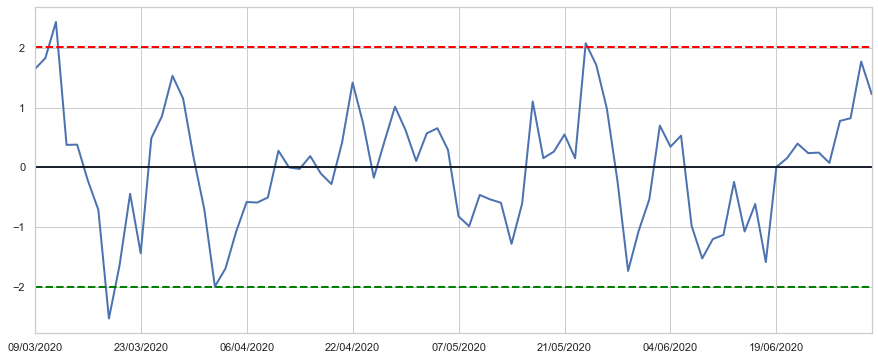

In [479]:
plot_residue(residue(y, x, period))

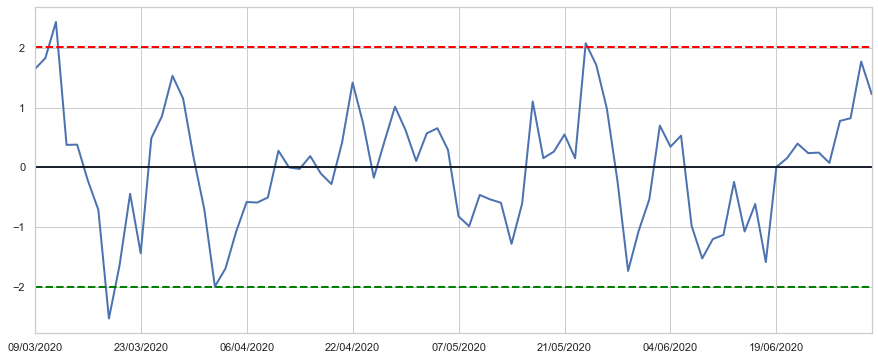

In [480]:
plot_residue(reg.resid)

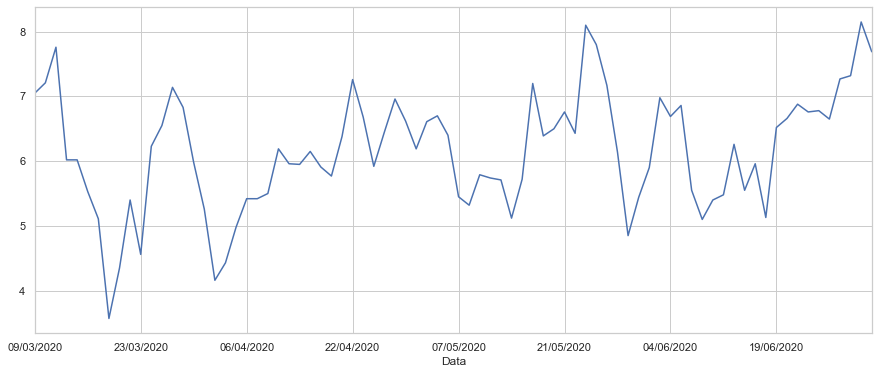

In [482]:
ratio_continuo(y, x, period)[::-1].plot(figsize=(15,6))